We look to compute traveling wave solutions of

\begin{align*}
u_t + 6 uu_x + u_{xxx} = 0.
\end{align*}

We have seen that for $c \in \mathbb R$, we should consider the boundary-value problem

\begin{align*}
 \begin{cases}
 c w'(x) + \sigma w(x) w'(x) + w'''(x) = 0,\\
 w(0) = w(L),\\
 w'(0) = w'(L),\\
 w''(0) = w''(L).
 \end{cases}
\end{align*}

We are interested in the case where $\sigma = 1$.  But it will be convenient to use this as a continuation parameter.

Instead of considering the periodic boundary conditions, we add appropriate conditions to make a well-posed BVP when $\sigma = 0$: $L = 1$, $c = k^2 \pi^2$:

\begin{align*}
 \begin{cases}
 c w'(x) + w'''(x) = 0,\\
 w(0) = 0,\\
 w(L) = 0,\\
     w'(L) = \beta.
 \end{cases}
\end{align*}

In [1]:
using LinearAlgebra, SparseArrays, FiniteDifferences, Plots

In [592]:
m = 1999;
L = 1;
k = 3
β = k*pi*(-1)^k
c = k^2*pi^2
h = L/(m+1); #grid spacing depends on interval length
xs = h:h:L-h

0.0005:0.0005:0.9995

In [593]:
u = x -> sin.(k*pi*x)

#83 (generic function with 1 method)

In [594]:
method = FiniteDifferenceMethod([-1, 0, 1], 1)
display(method)
first = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       3
  order of derivative:   1
  grid:                  [-1, 0, 1]
  coefficients:          [-0.5, 0.0, 0.5]


3-element Vector{Float64}:
 -0.5
  0.0
  0.5

In [595]:
method = FiniteDifferenceMethod([-1, 0, 1, 2, 3], 3)
display(method)
left = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       5
  order of derivative:   3
  grid:                  [-1, 0, 1, 2, 3]
  coefficients:          [-1.5, 5.0, -6.0, 3.0, -0.5]


5-element Vector{Float64}:
 -1.5
  5.0
 -6.0
  3.0
 -0.5

In [596]:
method = FiniteDifferenceMethod([-2,-1, 0, 1, 2], 3)
display(method)
third = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       5
  order of derivative:   3
  grid:                  [-2, -1, 0, 1, 2]
  coefficients:          [-0.5, 1.0, 0.0, -1.0, 0.5]


5-element Vector{Float64}:
 -0.5
  1.0
  0.0
 -1.0
  0.5

In [597]:
method = FiniteDifferenceMethod([-2,-1, 0,1], 1)
display(method)
right = method.coefs |> Vector

FiniteDifferenceMethod:
  order of method:       4
  order of derivative:   1
  grid:                  [-2, -1, 0, 1]
  coefficients:          [0.16666666666666666, -1.0, 0.5, 0.3333333333333333]


4-element Vector{Float64}:
  0.16666666666666666
 -1.0
  0.5
  0.3333333333333333

In [598]:
bD = zeros(m)
D = Tridiagonal(fill(-1.0,m-1), fill(0.0,m), fill(1.0,m-1));
D = sparse(D);
D *= 0.5/h;

In [599]:
# bD3 = zeros(m)
# D3 = spzeros(m,m)
# D3[1,1:4] = left[2:end]
# D3[2,1:4] = third[2:end]
# D3[end-1,end-3:end] = third[1:end-1]
# D3[end,end-2:end] = third[1:end-2]
# for i = 3:m-2
#    D3[i,i-2:i+2] = third
# end
# vec = -right[1:end-2]/right[end]
# D3[end,end-2:end] += 0.5*vec
# D3 *= 1/h^3

# bD3[end] -= 0.5*β*h/right[end]
# bD3 *= 1/h^3;

bD3 = zeros(m)
D3 = spzeros(m,m)
D3[1,1:4] = left[2:end]
D3[2,1:4] = third[2:end]
D3[end-1,end-3:end] = third[1:end-1]
D3[end,end-2:end] = third[1:end-2]
for i = 3:m-2
   D3[i,i-2:i+2] = third
end
vec = -right[1:2]/right[end]
D3[end,end-1:end] += 0.5*vec
D3 *= 1/h^3

bD3[end] -= 0.5*β*h/right[end]
bD3 *= 1/h^3;

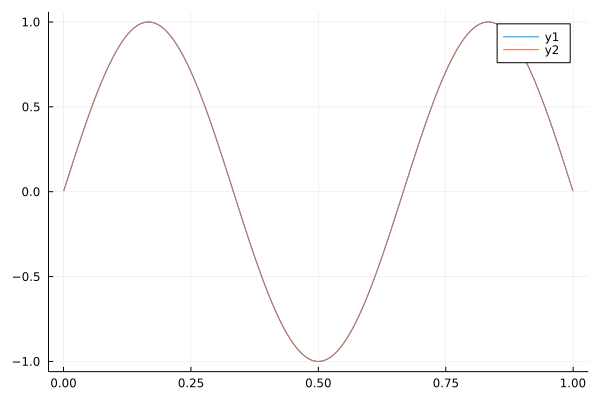

In [604]:
U = (c*D + D3)\(c*bD + bD3);
plot(xs,U)
plot!(xs,u(xs))

In [601]:
(U - u(xs))/h^2

1999-element Vector{Float64}:
 0.00019408810669752086
 0.0007735410714748703
 0.001739895186259055
 0.003090030675778621
 0.004825466817792723
 0.006943066829800948
 0.009444333148866946
 0.01232611224200042
 0.015589889740263985
 0.019232495318544096
 0.02325539813496924
 0.02765541137761396
 0.03243398766228367
 ⋮
 0.027654688178335718
 0.023254735997957354
 0.019231887637971568
 0.015589343621558172
 0.012325628212517259
 0.009443904047667928
 0.006942700220280429
 0.00482516271382849
 0.0030897824576658905
 0.001739709973302972
 0.0007734193285813262
 0.0001940227249697113

In [518]:
E = eigen(c*D + D3|>Array);

In [520]:
E.values

199-element Vector{ComplexF64}:
 8.616658924227593e-7 + 0.0im
    97.02938161392889 - 2.0772544530916575e7im
    97.02938161392889 + 2.0772544530916575e7im
   218.56438195168803 + 0.0im
    387.9873428619111 - 2.0756866722015824e7im
    387.9873428619111 + 2.0756866722015824e7im
    872.4833486464778 - 2.073075252301248e7im
    872.4833486464778 + 2.073075252301248e7im
   1105.1184988110385 + 0.0im
    1549.866559091637 - 2.0694225145694252e7im
    1549.866559091637 + 2.0694225145694252e7im
   2419.2259063848905 - 2.064731706266986e7im
   2419.2259063848905 + 2.064731706266986e7im
                      ⋮
   213552.52796955255 - 4.1115971136723612e6im
   213552.52796955255 + 4.1115971136723612e6im
   213710.83004269752 - 5.310630461573261e6im
   213710.83004269752 + 5.310630461573261e6im
   214208.56115515088 - 4.402008183948139e6im
   214208.56115515088 + 4.402008183948139e6im
    214270.8973305487 - 5.001958265984976e6im
    214270.8973305487 + 5.001958265984976e6im
   214442.48475117

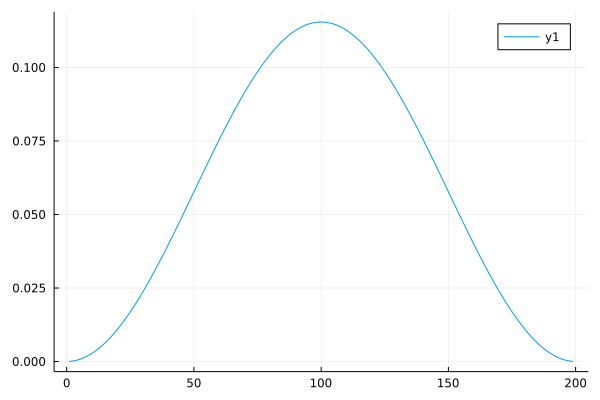

In [525]:
real(E.vectors[:,1]) |> plot